# Deep BSDE
Hedging option can be formulated as a BSDE problem:


This code is copy pasted and modified from:
https://github.com/YifanJiang233/Deep_BSDE_solver/tree/master.

Do I have to add a MIT license?

Note that the paper 

[1] E, W., Han, J., and Jentzen, A. Deep learning-based numerical methods for high-dimensional parabolic partial differential equations and backward stochastic differential equations, Communications in Mathematics and Statistics, 5, 349–380 (2017).

is referenced but no subnetworks are used but a network that also takes in time. 
The actual implementation is for 

https://arxiv.org/pdf/2101.01869.pdf

[2] Jiang,Y., Li, J. Convergence of the deep bsde method for fbsdes with non-lipschitz coefficients.

In [3]:
!pip install parameterfree


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\isido\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from parameterfree import COCOB

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class fbsde():
    def __init__(self, x_0, b, sigma, f, g, T, dim_x,dim_y,dim_d, guess_y_0 = [0,1] ):
        self.x_0 = x_0.to(device)
        self.b = b
        self.sigma = sigma
        self.f = f
        self.g = g
        self.T = T
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_d = dim_d
        self.guess_y_0 = guess_y_0 # range


class Model(nn.Module):
    def __init__(self, equation, dim_h):
        super(Model, self).__init__()
        self.equation= equation

        # specifying parameters of NN
        l = torch.rand(equation.dim_y, device=device)
        self.y_0 = nn.Parameter(equation.guess_y_0[0]*l+ equation.guess_y_0[1]*(1-l))
        self.linear1 = nn.Linear(equation.dim_x+1, dim_h) # dim_x + 1  the extra 1 for time
        self.linear2 = nn.Linear(dim_h, dim_h)
        self.linear3 = nn.Linear(dim_h, dim_h)
        self.linear4 = nn.Linear(dim_h, equation.dim_y*equation.dim_d)
        self.bn1 =nn.BatchNorm1d(dim_h)
        self.bn2 =nn.BatchNorm1d(dim_h)
    
    def get_z(self,x,t):
        tmp = torch.cat((x, t*torch.ones(x.size()[0], 1,device=device)), 1)
        tmp = F.gelu(self.linear1(tmp))
        tmp = self.bn1(F.gelu(self.linear2(tmp)))
        tmp = self.bn2(F.gelu(self.linear3(tmp)))
        return self.linear4(tmp).reshape(-1, self.equation.dim_y, self.equation.dim_d)
        

    def forward(self,batch_size, N):
        dt = self.equation.T / N
        x = self.equation.x_0+torch.zeros(batch_size,self.equation.dim_x,device=device)
        y = self.y_0+torch.zeros(batch_size,self.equation.dim_y,device=device)

        for i in range(N):
            t = dt*i
            z = self.get_z(x,t)

            dW = torch.randn(batch_size, self.equation.dim_d, 1, device=device) * np.sqrt(dt)
            x = x+self.equation.b(t, x, y)*dt+torch.matmul( self.equation.sigma(t, x), dW).reshape(-1, self.equation.dim_x)
            y = y-self.equation.f(t, x, y, z)*dt + torch.matmul(z, dW).reshape(-1, self.equation.dim_y)
        return x, y



class BSDEsolver():
    def __init__(self, equation, dim_h):
        self.model = Model(equation,dim_h).to(device)
        self.equation = equation

    def train(self, batch_size, N, itr, log):
        criterion = torch.nn.MSELoss().to(device)
        # optimizer = torch.optim.Adam(self.model.parameters())
        optimizer = COCOB(self.model.parameters())
        loss_data, y0_data = [], []

        for i in range(itr):
            x, y = self.model(batch_size,N)
            loss = criterion(self.equation.g(x), y)
            loss_data.append(float(loss))
            y0_data.append(float(self.model.y_0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if log  and i%int(itr/20) == 0:
                print(f"loss: {float(loss):7.2f} y0: {float(self.model.y_0):7.2f} done: {i/itr*100:5.2f}% Iteration: {i}")
        return loss_data, y0_data
            

In [23]:
mu = 0.07
sig = 0.3
r = 0.02
K = 110
dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 1, 1, 1, 11, 10, 1000, 1000
guess_y_0 = [15,17]

x_0, T = 100*torch.ones(dim_x), 1


def b(t, x, y):
    return mu*x


def sigma(t, x):
    return sig*x.reshape(batch_size, dim_x, dim_d)

#f_american doesnt work
def f_american(t, x, y, z):
    return (-r*y + r*K* (y<=g(x))).reshape(batch_size, dim_y)

def f_europian(t, x, y, z):
    return (-r*y ).reshape(batch_size, dim_y)


def g(x):
    return torch.max(K-x, torch.zeros(batch_size, dim_y, device=device)) 


equation = fbsde(x_0, b, sigma, f_europian, g, T,dim_x, dim_y, dim_d, guess_y_0)

bsde_solver = BSDEsolver(equation, dim_h)

loss:  309.16 y0:   16.01 done:  0.00% Iteration: 0
loss:  311.46 y0:   15.97 done:  5.00% Iteration: 5
loss:  295.88 y0:   15.91 done: 10.00% Iteration: 10
loss:  323.34 y0:   15.82 done: 15.00% Iteration: 15
loss:  275.58 y0:   15.68 done: 20.00% Iteration: 20
loss:  168.42 y0:   15.40 done: 25.00% Iteration: 25
loss:   64.59 y0:   14.89 done: 30.00% Iteration: 30
loss:   51.82 y0:   14.50 done: 35.00% Iteration: 35
loss:   54.17 y0:   14.12 done: 40.00% Iteration: 40
loss:   49.65 y0:   13.92 done: 45.00% Iteration: 45
loss:   48.34 y0:   13.86 done: 50.00% Iteration: 50
loss:   52.92 y0:   13.86 done: 55.00% Iteration: 55
loss:   47.60 y0:   13.82 done: 60.00% Iteration: 60
loss:   49.32 y0:   13.97 done: 65.00% Iteration: 65
loss:   58.89 y0:   13.89 done: 70.00% Iteration: 70
loss:   52.29 y0:   13.72 done: 75.00% Iteration: 75
loss:   54.03 y0:   13.73 done: 80.00% Iteration: 80
loss:   49.90 y0:   13.67 done: 85.00% Iteration: 85
loss:   56.78 y0:   13.79 done: 90.00% Iteration

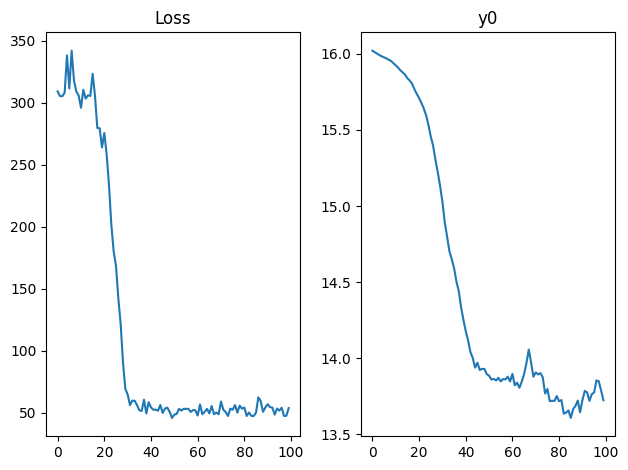

loss:   20.84 y0:   13.79 done:  0.00% Iteration: 0
loss:   17.47 y0:   13.82 done:  5.00% Iteration: 5
loss:   19.01 y0:   13.85 done: 10.00% Iteration: 10
loss:   17.25 y0:   13.88 done: 15.00% Iteration: 15
loss:   16.85 y0:   13.93 done: 20.00% Iteration: 20
loss:   19.34 y0:   13.99 done: 25.00% Iteration: 25
loss:   17.60 y0:   14.02 done: 30.00% Iteration: 30
loss:   16.61 y0:   14.08 done: 35.00% Iteration: 35
loss:   16.03 y0:   14.08 done: 40.00% Iteration: 40
loss:   17.01 y0:   14.08 done: 45.00% Iteration: 45
loss:   15.80 y0:   14.05 done: 50.00% Iteration: 50
loss:   15.97 y0:   14.04 done: 55.00% Iteration: 55
loss:   15.97 y0:   14.07 done: 60.00% Iteration: 60
loss:   16.03 y0:   14.04 done: 65.00% Iteration: 65
loss:   17.98 y0:   14.05 done: 70.00% Iteration: 70
loss:   18.19 y0:   14.05 done: 75.00% Iteration: 75
loss:   14.04 y0:   14.06 done: 80.00% Iteration: 80
loss:   16.27 y0:   14.03 done: 85.00% Iteration: 85
loss:   16.10 y0:   14.06 done: 90.00% Iteration

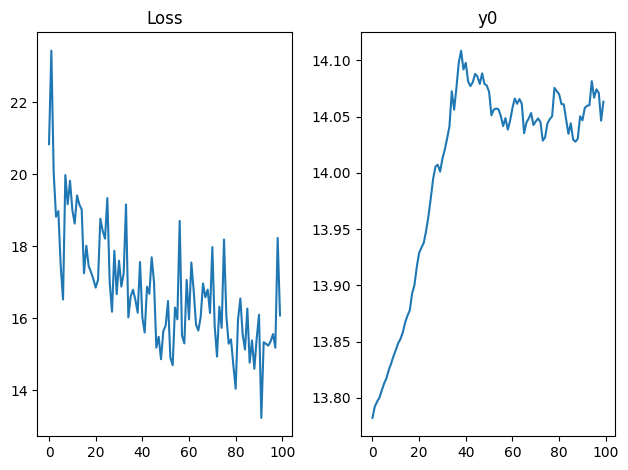

loss:    8.54 y0:   14.05 done:  0.00% Iteration: 0
loss:   10.57 y0:   14.07 done:  5.00% Iteration: 5
loss:   10.99 y0:   14.09 done: 10.00% Iteration: 10
loss:    9.49 y0:   14.08 done: 15.00% Iteration: 15
loss:    9.52 y0:   14.06 done: 20.00% Iteration: 20
loss:   10.11 y0:   14.05 done: 25.00% Iteration: 25
loss:   10.48 y0:   14.06 done: 30.00% Iteration: 30
loss:    9.76 y0:   14.07 done: 35.00% Iteration: 35
loss:   10.71 y0:   14.08 done: 40.00% Iteration: 40
loss:    8.21 y0:   14.07 done: 45.00% Iteration: 45
loss:    7.83 y0:   14.07 done: 50.00% Iteration: 50
loss:    8.09 y0:   14.09 done: 55.00% Iteration: 55
loss:    7.05 y0:   14.09 done: 60.00% Iteration: 60
loss:    7.48 y0:   14.09 done: 65.00% Iteration: 65
loss:    8.27 y0:   14.09 done: 70.00% Iteration: 70
loss:   10.39 y0:   14.08 done: 75.00% Iteration: 75
loss:    8.47 y0:   14.08 done: 80.00% Iteration: 80
loss:    7.05 y0:   14.09 done: 85.00% Iteration: 85
loss:    7.77 y0:   14.09 done: 90.00% Iteration

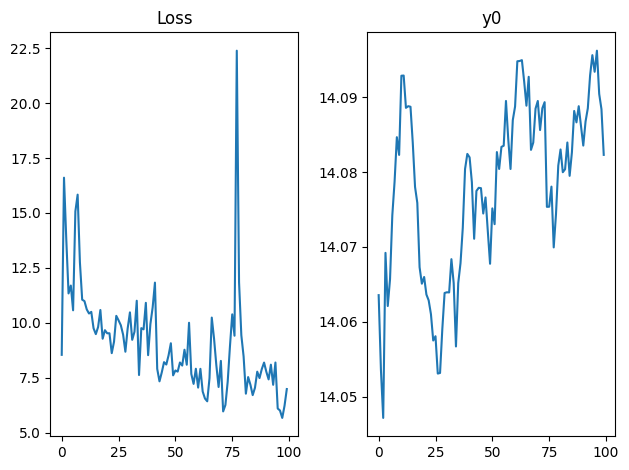

In [24]:
import matplotlib.pyplot as plt

torch.manual_seed(46)
# NN = [1,5,10,20,40]
# itrs = [100,100,100,100,100]
# batch_sizes = [100, 100,100,100, 1000]

NN = [2,10,40]
itrs = [100,100,100]
batch_sizes = [1000,1000,1000]
for N,itr,batch_size in zip(NN,itrs,batch_sizes): 
    loss, y0=bsde_solver.train(batch_size, N,itr, log=True)
    fig, axs = plt.subplots(1,2)
    axs[0].plot(loss)
    axs[0].set_title('Loss')

    axs[1].plot(y0)
    axs[1].set_title('y0')

    plt.tight_layout()
    plt.show()